# 코드 실행기
`15_code_interpreter.ipynb`

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## State

In [2]:
from langgraph.graph import MessagesState
from typing_extensions import Any

class State(MessagesState):
    question: str  # 사용자 질문
    dataset: Any   # 임의이 데이터셋(추후엔 DB에서 가져오거나 해야함)
    code: str      # 파이썬 코드 블럭
    result: str    # `code`의 실행결과
    answer: str    # 최종 답변

## Node

In [3]:
# %pip install -q langchain_experimental

In [4]:
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict, Annotated
from langchain_experimental.utilities import PythonREPL
import os
import uuid

llm = ChatOpenAI(model='gpt-4o', temperature=0)

class CodeBlock(TypedDict):
    code: Annotated[str, ..., '바로 실행 가능한 파이썬 코드']


def generate_code(state: State):
    prompt = f'''
    사용자 질문과 데이터셋을 제공할거야. 사용자 질문에 답변하기 위한 파이썬 코드를 생성해 줘.
    코드는 간단할수록 좋고, numpy, pandas, scikit-learn, scipy 가 설치되어 있으니 편하게 사용해.
    [주의] 이 코드는 실행될거기 때문에, 위험한 코드는 작성하면 안돼!
    ---
    질문: {state['question']}
    ---
    데이터셋: {state['dataset']}
    ---
    코드: 
    '''
    s_llm = llm.with_structured_output(CodeBlock)
    res = s_llm.invoke(prompt)
    return {'code': res['code']}


def execute_code(state: State):
    repl = PythonREPL()
    result = repl.run(state['code'])
    return {'result': result.strip()}


def generate_answer(state: State):
    prompt = f'''
    우리는 사용자 질문 -> 코드 -> 결과를 가지고 있어
    사용자의 질문과, 실행코드와 결과를 종합해 최종 답변을 생성해라.
    실행코드를 기반으로 왜 이 결과가 나왔는지 설명하면 된다.
    ---
    질문: {state['question']}
    ---
    코드: {state['code']}
    ---
    결과: {state['result']}
    ---
    최종 답변:
    '''
    res = llm.invoke(prompt)
    return {'answer': res}


def save_code(state: State):
    """
    코드를 특정 폴더에 저장합니다.
    """
    # 'codes' 폴더가 없으면 생성
    if not os.path.exists("codes"):
        os.makedirs("codes")

    # 고유한 파일 이름 생성
    filename = f"codes/code_{uuid.uuid4()}.py"
    
    # state에서 질문과 코드 가져오기
    question = state.get('question', 'No question provided.')
    code_to_save = state.get('code', '')

    # 질문을 docstring으로 추가
    docstring = f'"""\n[USER QUESTION]\n{question}\n"""\n\n'
    content_to_save = docstring + code_to_save
    
    # 파일에 코드 저장
    with open(filename, "w", encoding="utf-8") as f:
        f.write(content_to_save)
        
    # 상태를 변경하지 않고 다음 노드로 진행하기 위해 빈 딕셔너리 반환
    return {}

## Graph

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(State)
builder.add_sequence([generate_code, execute_code, save_code, generate_answer])

builder.add_edge(START, 'generate_code')
builder.add_edge('generate_answer', END)

memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

In [6]:
config = {
    'configurable': {'thread_id': '1'}
}
question = '키를 기반으로 몸무게를 예측해야해. 키는 173이야.'
dataset = {
    "heights": [
        150, 152, 154, 156, 158, 
        160, 161, 162, 163, 164, 
        165, 166, 167, 168, 169, 
        170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 
        180, 181, 182, 183, 185
    ],
    "weights": [
        45, 48, 49, 50, 52, 
        54, 55, 56, 57, 58, 
        59, 60, 61, 62, 63, 
        64, 65, 66, 67, 68, 
        70, 71, 72, 73, 74, 
        75, 77, 78, 79, 82
    ]
}

for step in graph.stream({
    'question': question,
    'dataset': dataset
}, config):
    print(step)

Python REPL can execute arbitrary code. Use with caution.


{'generate_code': {'code': 'import numpy as np\nimport pandas as pd\nfrom sklearn.linear_model import LinearRegression\n\n# 데이터셋 정의\ndata = {\n    \'heights\': [150, 152, 154, 156, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185],\n    \'weights\': [45, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 82]\n}\n\n# 데이터프레임 생성\ndf = pd.DataFrame(data)\n\n# 독립 변수와 종속 변수 설정\nX = df[[\'heights\']]\ny = df[\'weights\']\n\n# 선형 회귀 모델 생성 및 학습\nmodel = LinearRegression()\nmodel.fit(X, y)\n\n# 키 173에 대한 몸무게 예측\nheight_to_predict = np.array([[173]])\npredicted_weight = model.predict(height_to_predict)\n\nprint(f"Predicted weight for height 173 cm: {predicted_weight[0]:.2f} kg")'}}


c:\Users\IP_Time\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


{'execute_code': {'result': 'Predicted weight for height 173 cm: 67.79 kg'}}
{'save_code': None}
{'generate_answer': {'answer': AIMessage(content='키 173cm에 대한 몸무게를 예측하기 위해 선형 회귀 모델을 사용했습니다. 주어진 데이터셋은 키와 그에 대응하는 몸무게로 구성되어 있으며, 이를 기반으로 모델을 학습시켰습니다. \n\n선형 회귀는 두 변수 간의 관계를 직선으로 모델링하는 방법입니다. 이 경우, 키(독립 변수)와 몸무게(종속 변수) 간의 관계를 직선으로 표현하여, 특정 키에 대한 몸무게를 예측할 수 있습니다. \n\n모델을 학습한 후, 키가 173cm일 때의 몸무게를 예측한 결과, 약 67.79kg으로 계산되었습니다. 이는 학습된 모델이 데이터셋 내의 패턴을 기반으로 예측한 값입니다. 따라서, 키가 173cm인 사람의 몸무게는 약 67.79kg일 것으로 예상할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 203, 'prompt_tokens': 453, 'total_tokens': 656, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CElZn4pxJUvGaGCjItnsqc0e2QHT1', 'service_tier': 'de

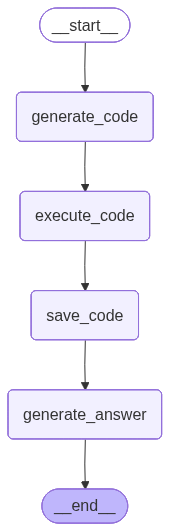

In [7]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())